In [1]:
import pandas as pd
import numpy as np
import torch
import json
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import scipy.stats as stats
import os

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer



In [2]:
# defining model_type and tokenizer to count number of tokens in names
model_type = "google/flan-t5-xl"
tokenizer = AutoTokenizer.from_pretrained(model_type)

# Read Results of Bootstrap_V1

## Reading results of bAbI

In [3]:
df_full_data = {}
df = {}
folder_names = ['demons', 'demons+query', 'query']
tasks = [1,12,14,16]
for folder_name in folder_names:
    df_full_data[folder_name] = {}
    df[folder_name] = pd.DataFrame()
    for task in tasks:
        data_file = f'./bAbI/v_1_names/{folder_name}/task_{task}.csv'
        df_full_data[folder_name][f'task_{task}'] = pd.read_csv(data_file)
        df_full_data[folder_name][f'task_{task}']['check_ans'] = df_full_data[folder_name][f'task_{task}']['gen_ans'] == df_full_data[folder_name][f'task_{task}']['actual_ans']

        if task == 1: # add entity column
            df[folder_name]['entity'] = sorted(set(df_full_data[folder_name][f'task_{task}']['entity'].values))
        df[folder_name][f'acc_task_{task}'] = df_full_data[folder_name][f'task_{task}'][['entity', 'check_ans']].groupby('entity').mean().reset_index()['check_ans']


In [4]:
# tokenizing names
names = df['demons']['entity'].values
name_to_tokens = {}
for name in names:
    name_to_tokens[name] = []
    tokens = tokenizer.encode(' ' + name, return_tensors="pt")[0]
    for token in tokens:
        if token == tokenizer.eos_token_id:
            continue
        name_to_tokens[name].append(tokenizer.decode(token))

In [5]:
#baseline
baseline_full_data = {}
baseline = pd.DataFrame()
for task in tasks:
    data_file =f'./bAbI//baseline/task_{task}.csv'
    baseline_full_data[f'task_{task}'] = pd.read_csv(data_file)
    baseline[f'acc_task_{task}'] = [baseline_full_data[f'task_{task}']['accuracy'][0]*100]
baseline

,acc_task_1,acc_task_12,acc_task_14,acc_task_16
0,100.0,95.0,78.0,56.0


In [6]:
df['demons'].head()

,entity,acc_task_1,acc_task_12,acc_task_14,acc_task_16
0,Abelardo,1.0,0.93,0.77,0.57
1,Adriane,1.0,0.95,0.77,0.58
2,Ahmad,1.0,0.95,0.78,0.58
3,Alina,1.0,0.95,0.76,0.57
4,Alisha,1.0,0.95,0.77,0.58


## Reading results of CLUTRR

In [7]:
aug_to_clutrr = {'demons': 'cluttr_val_aug_demonstrations.jsonl',
                 'demons+query': 'cluttr_val_aug_query_and_demonstrations.jsonl',
                 'query': 'cluttr_val_aug_query.jsonl'}

In [8]:
for aug in folder_names:
    data_m = []
    data_w = []
    file_path = f'./CLUTRR/set_1/male/{aug_to_clutrr[aug]}'
    with open (file_path, 'r') as f:
        for line in f:
            data_m.append(json.loads(line))
    file_path = f'./CLUTRR/set_1/female/{aug_to_clutrr[aug]}'
    with open (file_path, 'r') as f:
        for line in f:
            data_w.append(json.loads(line))
    data_comb = data_m + data_w
    df_tmp = pd.DataFrame(data_comb)
    df[aug] = pd.merge(df[aug], df_tmp[['entity', 'accuracy']], left_on='entity', right_on='entity', how='left')
    df[aug].rename(columns={'accuracy': 'acc_task_21'}, inplace=True)
    df[aug] = df[aug]

## Reading results of GSM8k

In [9]:
data_g = []
file_path = './GSM8k/gsm_bootstrap1.jsonl'
with open (file_path, 'r') as f:
        for line in f:
            data_g.append(json.loads(line))

In [10]:
aug_to_gsm = {'demons': 'demonstrations',
                 'demons+query': 'both',
                 'query': 'query'}

dic_tmp = {'demonstrations': [],
           'both': [],
           'query': []}

for i in range(len(data_g)):
    tmp = {'entity': data_g[i]['entity_augmentation'].split('_')[-1],
           'accuracy': data_g[i]['validation']['accuracy']}
    dic_tmp[data_g[i]['prompt_augmentation']].append(tmp)

for aug in folder_names:
    df_tmp = pd.DataFrame(dic_tmp[aug_to_gsm[aug]])
    df[aug] = pd.merge(df[aug], df_tmp[['entity', 'accuracy']], left_on='entity', right_on='entity', how='left')
    df[aug].rename(columns={'accuracy': 'acc_task_22'}, inplace=True)

In [11]:
# revise baseline
baseline['acc_task_21'] = [60]
baseline['acc_task_22'] = [12]

In [12]:
baseline

,acc_task_1,acc_task_12,acc_task_14,acc_task_16,acc_task_21,acc_task_22
0,100.0,95.0,78.0,56.0,60,12


# Reading results of V_2 names for all datasets

In [13]:
df_full_data_v2 = {}
df_v2 = {}
folder_names = ['demons', 'demons+query', 'query']
tasks = [1,12,14,16]
for folder_name in folder_names:
    df_full_data_v2[folder_name] = {}
    df_v2[folder_name] = pd.DataFrame()
    for task in tasks:
        data_file = f'./bAbI/v_2_names/{folder_name}/task_{task}.csv'
        df_full_data_v2[folder_name][f'task_{task}'] = pd.read_csv(data_file)
        df_full_data_v2[folder_name][f'task_{task}']['check_ans'] = df_full_data_v2[folder_name][f'task_{task}']['gen_ans'] == df_full_data_v2[folder_name][f'task_{task}']['actual_ans']

        if task == 1: # add entity column
            df_v2[folder_name]['entity'] = sorted(set(df_full_data_v2[folder_name][f'task_{task}']['entity'].values))
        df_v2[folder_name][f'acc_task_{task}'] = df_full_data_v2[folder_name][f'task_{task}'][['entity', 'check_ans']].groupby('entity').mean().reset_index()['check_ans']


In [14]:
for aug in folder_names:
    data_m = []
    data_w = []
    file_path = f'./CLUTRR/set_2/male/{aug_to_clutrr[aug]}'
    with open (file_path, 'r') as f:
        for line in f:
            data_m.append(json.loads(line))
    file_path = f'./CLUTRR/set_2/female/{aug_to_clutrr[aug]}'
    with open (file_path, 'r') as f:
        for line in f:
            data_w.append(json.loads(line))
    data_comb = data_m + data_w
    df_tmp = pd.DataFrame(data_comb)
    df_v2[aug] = pd.merge(df_v2[aug], df_tmp[['entity', 'accuracy']], left_on='entity', right_on='entity', how='left')
    df_v2[aug].rename(columns={'accuracy': 'acc_task_21'}, inplace=True)

In [15]:
data_g = []
file_path = './GSM8k/gsm_bootstrap2.jsonl'
with open (file_path, 'r') as f:
        for line in f:
            data_g.append(json.loads(line))

In [16]:
aug_to_gsm = {'demons': 'demonstrations',
                 'demons+query': 'both',
                 'query': 'query'}

dic_tmp = {'demonstrations': [],
           'both': [],
           'query': []}

for i in range(len(data_g)):
    tmp = {'entity': data_g[i]['entity_augmentation'].split('_')[-1],
           'accuracy': data_g[i]['validation']['accuracy']}
    dic_tmp[data_g[i]['prompt_augmentation']].append(tmp)

for aug in folder_names:
    df_tmp = pd.DataFrame(dic_tmp[aug_to_gsm[aug]])
    df_v2[aug] = pd.merge(df_v2[aug], df_tmp[['entity', 'accuracy']], left_on='entity', right_on='entity', how='left')
    df_v2[aug].rename(columns={'accuracy': 'acc_task_22'}, inplace=True)

# Reading results of v_3 names for all datasets

In [17]:
df_full_data_v3 = {}
df_v3 = {}
folder_names = ['demons', 'demons+query', 'query']
tasks = [1,12,14,16]
for folder_name in folder_names:
    df_full_data_v3[folder_name] = {}
    df_v3[folder_name] = pd.DataFrame()
    for task in tasks:
        data_file = f'./bAbI/v_3_names/{folder_name}/task_{task}.csv'
        df_full_data_v3[folder_name][f'task_{task}'] = pd.read_csv(data_file)
        df_full_data_v3[folder_name][f'task_{task}']['check_ans'] = df_full_data_v3[folder_name][f'task_{task}']['gen_ans'] == df_full_data_v3[folder_name][f'task_{task}']['actual_ans']

        if task == 1: # add entity column
            df_v3[folder_name]['entity'] = sorted(set(df_full_data_v3[folder_name][f'task_{task}']['entity'].values))
        df_v3[folder_name][f'acc_task_{task}'] = df_full_data_v3[folder_name][f'task_{task}'][['entity', 'check_ans']].groupby('entity').mean().reset_index()['check_ans']


In [18]:
for aug in folder_names:
    data_m = []
    data_w = []
    file_path = f'./CLUTRR/set_3/male/{aug_to_clutrr[aug]}'
    with open (file_path, 'r') as f:
        for line in f:
            data_m.append(json.loads(line))
    file_path = f'./CLUTRR/set_3/female/{aug_to_clutrr[aug]}'
    with open (file_path, 'r') as f:
        for line in f:
            data_w.append(json.loads(line))
    data_comb = data_m + data_w
    df_tmp = pd.DataFrame(data_comb)
    df_v3[aug] = pd.merge(df_v3[aug], df_tmp[['entity', 'accuracy']], left_on='entity', right_on='entity', how='left')
    df_v3[aug].rename(columns={'accuracy': 'acc_task_21'}, inplace=True)

In [19]:
data_g = []
file_path = './GSM8k/gsm_bootstrap3.jsonl'
with open (file_path, 'r') as f:
        for line in f:
            data_g.append(json.loads(line))

In [20]:
aug_to_gsm = {'demons': 'demonstrations',
                 'demons+query': 'both',
                 'query': 'query'}

dic_tmp = {'demonstrations': [],
           'both': [],
           'query': []}

for i in range(len(data_g)):
    tmp = {'entity': data_g[i]['entity_augmentation'].split('_')[-1],
           'accuracy': data_g[i]['validation']['accuracy']}
    dic_tmp[data_g[i]['prompt_augmentation']].append(tmp)

for aug in folder_names:
    df_tmp = pd.DataFrame(dic_tmp[aug_to_gsm[aug]])
    df_v3[aug] = pd.merge(df_v3[aug], df_tmp[['entity', 'accuracy']], left_on='entity', right_on='entity', how='left')
    df_v3[aug].rename(columns={'accuracy': 'acc_task_22'}, inplace=True)

# Reading results of GPT-J for V1 names and all datasets

In [21]:
df_full_data_vj = {}
df_vj = {}
folder_names = ['demons', 'demons+query', 'query']
tasks = [1,12,14,16]
for folder_name in folder_names:
    df_full_data_vj[folder_name] = {}
    df_vj[folder_name] = pd.DataFrame()
    for task in tasks:
        data_file = f'./bAbI/v_1_names/GPT_J/{folder_name}/task_{task}.csv'
        df_full_data_vj[folder_name][f'task_{task}'] = pd.read_csv(data_file)
        df_full_data_vj[folder_name][f'task_{task}']['check_ans'] = df_full_data_vj[folder_name][f'task_{task}']['gen_ans'] == df_full_data_vj[folder_name][f'task_{task}']['actual_ans']

        if task == 1: # add entity column
            df_vj[folder_name]['entity'] = sorted(set(df_full_data_vj[folder_name][f'task_{task}']['entity'].values))
        df_vj[folder_name][f'acc_task_{task}'] = df_full_data_vj[folder_name][f'task_{task}'][['entity', 'check_ans']].groupby('entity').mean().reset_index()['check_ans']


In [22]:
#baseline
baseline_j_full_data = {}
baseline_j = pd.DataFrame()
for task in tasks:
    data_file =f'./bAbI/baseline/GPT_J/task_{task}.csv'
    baseline_j_full_data[f'task_{task}'] = pd.read_csv(data_file)
    baseline_j[f'acc_task_{task}'] = [baseline_j_full_data[f'task_{task}']['accuracy'][0]*100]

In [23]:
baseline_j

,acc_task_1,acc_task_12,acc_task_14,acc_task_16
0,75.0,77.0,70.0,45.0


## multiplying acc by 100

In [24]:
tasks = [1,12,14,16]
allTasks = [1,12,14,16,21,22]
for aug in folder_names:
    for task in allTasks:
        df[aug][f'acc_task_{task}'] = df[aug][f'acc_task_{task}'] * 100
        df_v2[aug][f'acc_task_{task}'] = df_v2[aug][f'acc_task_{task}'] * 100
        df_v3[aug][f'acc_task_{task}'] = df_v3[aug][f'acc_task_{task}'] * 100
    for task in tasks:
        df_vj[aug][f'acc_task_{task}'] = df_vj[aug][f'acc_task_{task}'] * 100

In [25]:
baseline

,acc_task_1,acc_task_12,acc_task_14,acc_task_16,acc_task_21,acc_task_22
0,100.0,95.0,78.0,56.0,60,12


# Ploting Deviation from baseline

In [26]:
task_to_labels = {1: 'bAbI Task 1',
               12: 'bAbI Task 12',
               14: 'bAbI Task 14',
               16: 'bAbI Task 16',
               21: 'CLUTRR',
               22: 'GSM8k'}

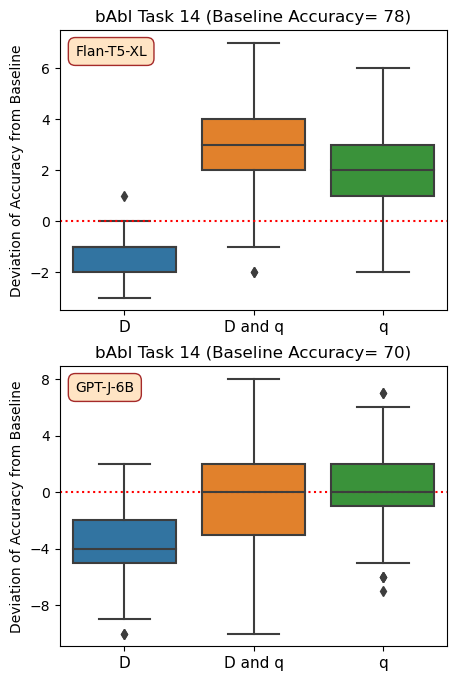

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))  # Create a 2x2 grid of subplots
axs = axs.flatten()  # Flatten the axes array for easy iterating

task = 14
for i, df_loop in enumerate([df, df_vj]):
    if i == 0:
        baseline_value = baseline[f"acc_task_{task}"][0]
        model_name = 'Flan-T5-XL'
    else:
        baseline_value = baseline_j[f"acc_task_{task}"][0]
        model_name = 'GPT-J-6B'

    # Calculate deviations for each case
    deviation_demonstrations = df_loop['demons'][f'acc_task_{task}'] - baseline_value
    deviation_both = df_loop['demons+query'][f'acc_task_{task}'] - baseline_value
    deviation_query = df_loop['query'][f'acc_task_{task}'] - baseline_value

    # Create a new DataFrame for the box plot
    df_tmp = pd.DataFrame({
        'deviation': deviation_demonstrations.tolist() + deviation_both.tolist() + deviation_query.tolist(),
        'type': ['D']*len(deviation_demonstrations) + ['D and q']*len(deviation_both) + ['q']*len(deviation_query)
    })

    # Create the box plot on the i-th subplot
    ax = sns.boxplot(x='type', y='deviation', data=df_tmp, ax=axs[i])
    ax.set_title(f"{task_to_labels[task]} (Baseline Accuracy= {baseline_value:.0f})")
    ax.set_ylabel(f"Deviation of Accuracy from Baseline")
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelsize=11)
    ax.axhline(y=0, ls=':', c='r')
    ax.text(0.04, 0.91, model_name, size=10, horizontalalignment='left', transform=ax.transAxes, bbox=dict(facecolor='bisque', edgecolor='brown', boxstyle='round,pad=0.5'))
    if i == 1:
        ax.set_yticks(np.arange(-8,9,4))

# plt.savefig('../../final_plots/updated_box_acc_task14_both.pdf', bbox_inches='tight', pad_inches=0.2, facecolor='white')

# Ploting bootstrap results

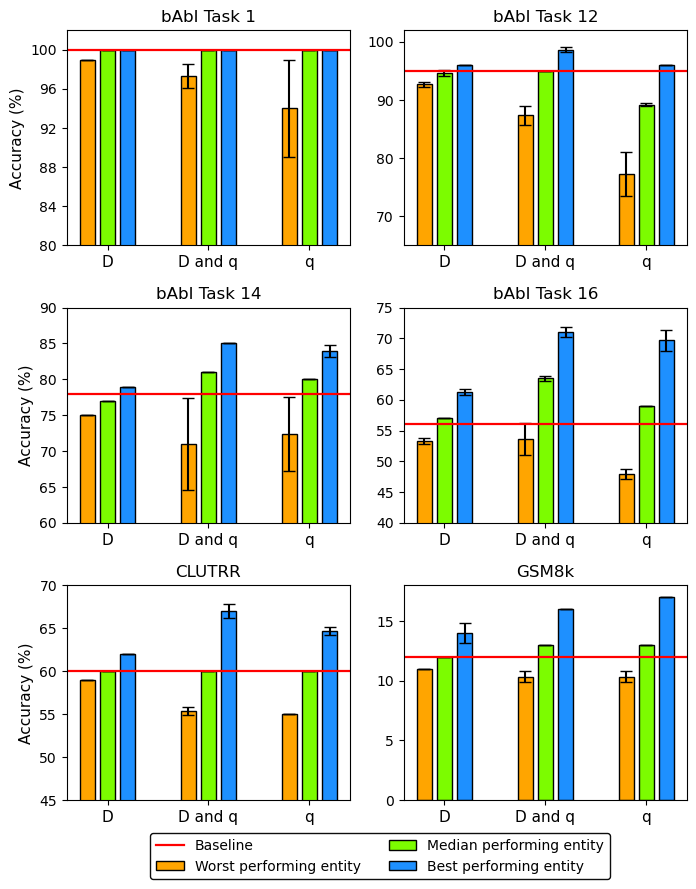

In [30]:
categories = ['D', 'D and q', 'q']
aug_labels = ['bAbI Task 1', 'bAbI Task 12', 'bAbI Task 14', 'bAbI Task 16', 'CLUTRR', 'GSM8k']
y_limits = [(80, 102), (65,102), (60,90), (40,75), (45,70), (0,18)]


fig, axs = plt.subplots(3, 2, figsize=(8,10), gridspec_kw={'hspace':0.29, 'wspace':0.19})
axs = axs.flatten()

for i, task in enumerate(allTasks):
    ax = axs[i]
    # prepare data
    list_min_err = [[] for _ in range(len(categories))]
    list_med_err = [[] for _ in range(len(categories))]
    list_max_err = [[] for _ in range(len(categories))]
    for j, aug in enumerate(folder_names):
        # errors
        list_min_err[j].append(df[aug][f'acc_task_{task}'].min())
        list_min_err[j].append(df_v2[aug][f'acc_task_{task}'].min())
        list_min_err[j].append(df_v3[aug][f'acc_task_{task}'].min())
        
        list_med_err[j].append(df[aug][f'acc_task_{task}'].median())
        list_med_err[j].append(df_v2[aug][f'acc_task_{task}'].median())
        list_med_err[j].append(df_v3[aug][f'acc_task_{task}'].median())
        
        list_max_err[j].append(df[aug][f'acc_task_{task}'].max())
        list_max_err[j].append(df_v2[aug][f'acc_task_{task}'].max())
        list_max_err[j].append(df_v3[aug][f'acc_task_{task}'].max())
        
        
        min_err = [np.std(x) for x in list_min_err]
        med_err = [np.std(x) for x in list_med_err]
        max_err = [np.std(x) for x in list_max_err]
        
        min_bar = [np.mean(x) for x in list_min_err]
        med_bar = [np.mean(x) for x in list_med_err]
        max_bar = [np.mean(x) for x in list_max_err]
        
    x = np.arange(len(categories))
    width = 0.15
    dist = 0.05
    
    # calculate modified error bars
    rects1 = ax.bar(x - (width + dist)*1, min_bar, width, color='orange', edgecolor = 'k', label='Worst performing entity', yerr=min_err, align='center', capsize=4)
    rects2 = ax.bar(x - (width + dist)*0, med_bar, width, color='lawngreen', edgecolor = 'k', label='Median performing entity', yerr=med_err, align='center', capsize=4)
    rects3 = ax.bar(x + (width + dist)*1, max_bar, width, color='dodgerblue', edgecolor = 'k', label='Best performing entity', yerr=max_err, align='center', capsize=4)
    
    ax.axhline(y=baseline[f"acc_task_{task}"][0], lw=1.6, c='r', label = 'Baseline')

    ax.set_xlabel('')
    ax.set_ylabel('Accuracy (%)', size=11)
    if i % 2 == 1:
        ax.set_ylabel('')
    ax.set_title(f'{aug_labels[i]}')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, size=11)
    ax.set_ylim(y_limits[i])
    if i == 0:
        ax.set_yticks(np.arange(80,101,4))
    if i == 4:
        legend = ax.legend(bbox_to_anchor=(0.27, -0.12), loc='upper left', ncol=2)
        legend.get_frame().set_alpha(0.95)
        legend.get_frame().set_edgecolor('black')

# plt.savefig('../../final_plots/updated_bootstrap_flan_v3.pdf', dpi=300, bbox_inches='tight', pad_inches=0.2, facecolor='white')

## Concat results of 3 sets of names

In [31]:
df_name = pd.read_csv('../data/demographic_updated.csv')
df_name.head()

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace,count_web,gender,prob
0,Aaron,3646,2.880,91.607,3.264,2.057,0.055,0.137,292748,male,1.00
1,Abbas,59,0.000,71.186,3.390,25.424,0.000,0.000,40851,male,0.99
2,Abbey,57,0.000,96.491,3.509,0.000,0.000,0.000,16048,female,0.90
3,Abbie,74,1.351,95.946,2.703,0.000,0.000,0.000,16641,female,0.99
4,Abby,262,1.527,94.656,1.527,2.290,0.000,0.000,56791,female,0.99


In [32]:
df_c = {}
for aug in folder_names:
    df_c[aug] = pd.concat([df[aug], df_v2[aug], df_v3[aug]], ignore_index=True)

In [33]:
# Merge df_acc with df_name on 'name' (in df_acc) and 'firstname' (in df_name)
df_acc_c = df_c['demons+query'].copy()
df_acc_c = pd.merge(df_acc_c, df_name[['firstname', 'obs', 'count_web', 'gender']], left_on='entity', right_on='firstname', how='left')

# Drop the 'firstname' column as it's the same as 'name'
df_acc_c.drop('firstname', axis=1, inplace=True)

# Frequency of names

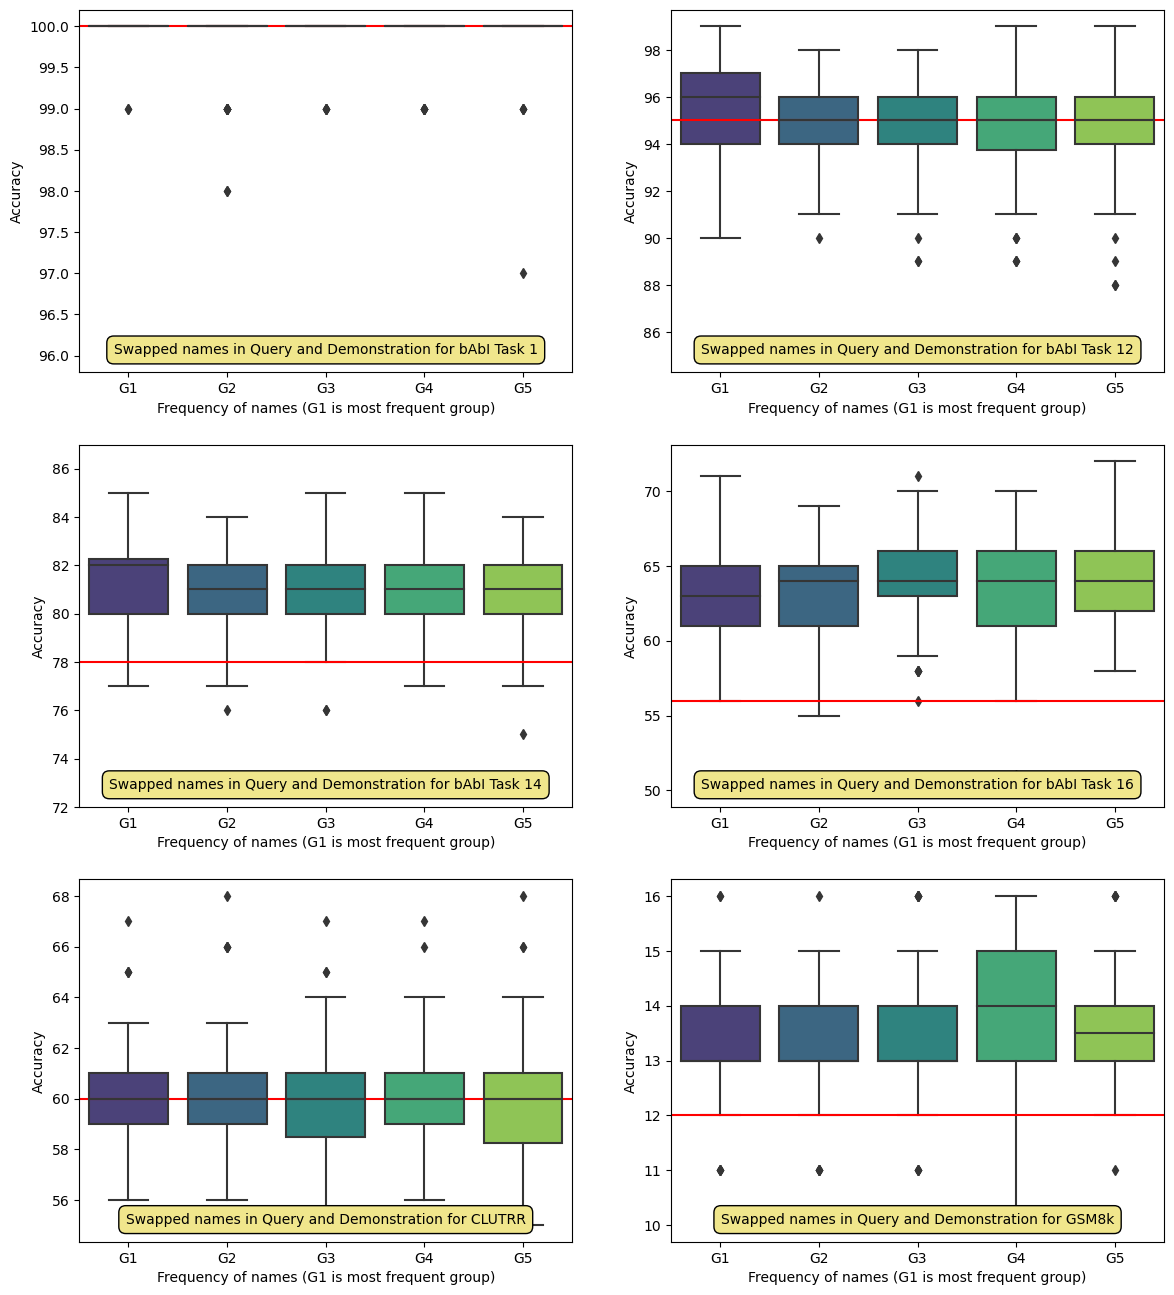

In [34]:
# Acc
col_tmp = 'obs'
# Define the bins
bins = [df_acc_c[col_tmp].quantile(0), df_acc_c[col_tmp].quantile(0.2), df_acc_c[col_tmp].quantile(0.4), 
        df_acc_c[col_tmp].quantile(0.6), df_acc_c[col_tmp].quantile(0.8), df_acc_c[col_tmp].quantile(1)]

# Define the labels
labels = ['G5', 'G4', 'G3', 'G2', 'G1']
df_acc_c['obs_g'] = pd.cut(df_acc_c[col_tmp], bins=bins, labels=labels)


fig, ax = plt.subplots(3, 2, figsize=(14, 16))  # create a 3x2 grid of subplots
tasks_indexes = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]  # indexes for the 3x2 grid

for i, task in enumerate(allTasks):
    row, col = tasks_indexes[i]  # get the position of the subplot for this task

    sns.boxplot(ax=ax[row, col], x='obs_g', y=f"acc_task_{task}", data=df_acc_c, palette='viridis', order=['G1', 'G2', 'G3', 'G4', 'G5'])
    ax[row, col].set_xlabel('Frequency of names (G1 is most frequent group)')
    ax[row, col].set_ylabel('Accuracy')
    ax[row, col].axhline(y=baseline[f'acc_task_{task}'][0], c='r')
    ax[row, col].text(0.5, 0.05, f"Swapped names in Query and Demonstration for {task_to_labels[task]}", horizontalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='khaki', edgecolor='black', boxstyle='round,pad=0.5'))
    if i == 2:
        ax[row, col].set_ylim(72, 87)
# plt.savefig('../../final_plots/updated_frequency_flan.pdf', bbox_inches='tight', pad_inches=0.2, facecolor='white')

# Token length of names

In [35]:
#token_length
token_lens = [tokenizer.encode(' ' + entity, return_tensors="pt").size(1) - 1 
              for entity in df_acc_c['entity'].values]
df_acc_c['token_len'] = token_lens

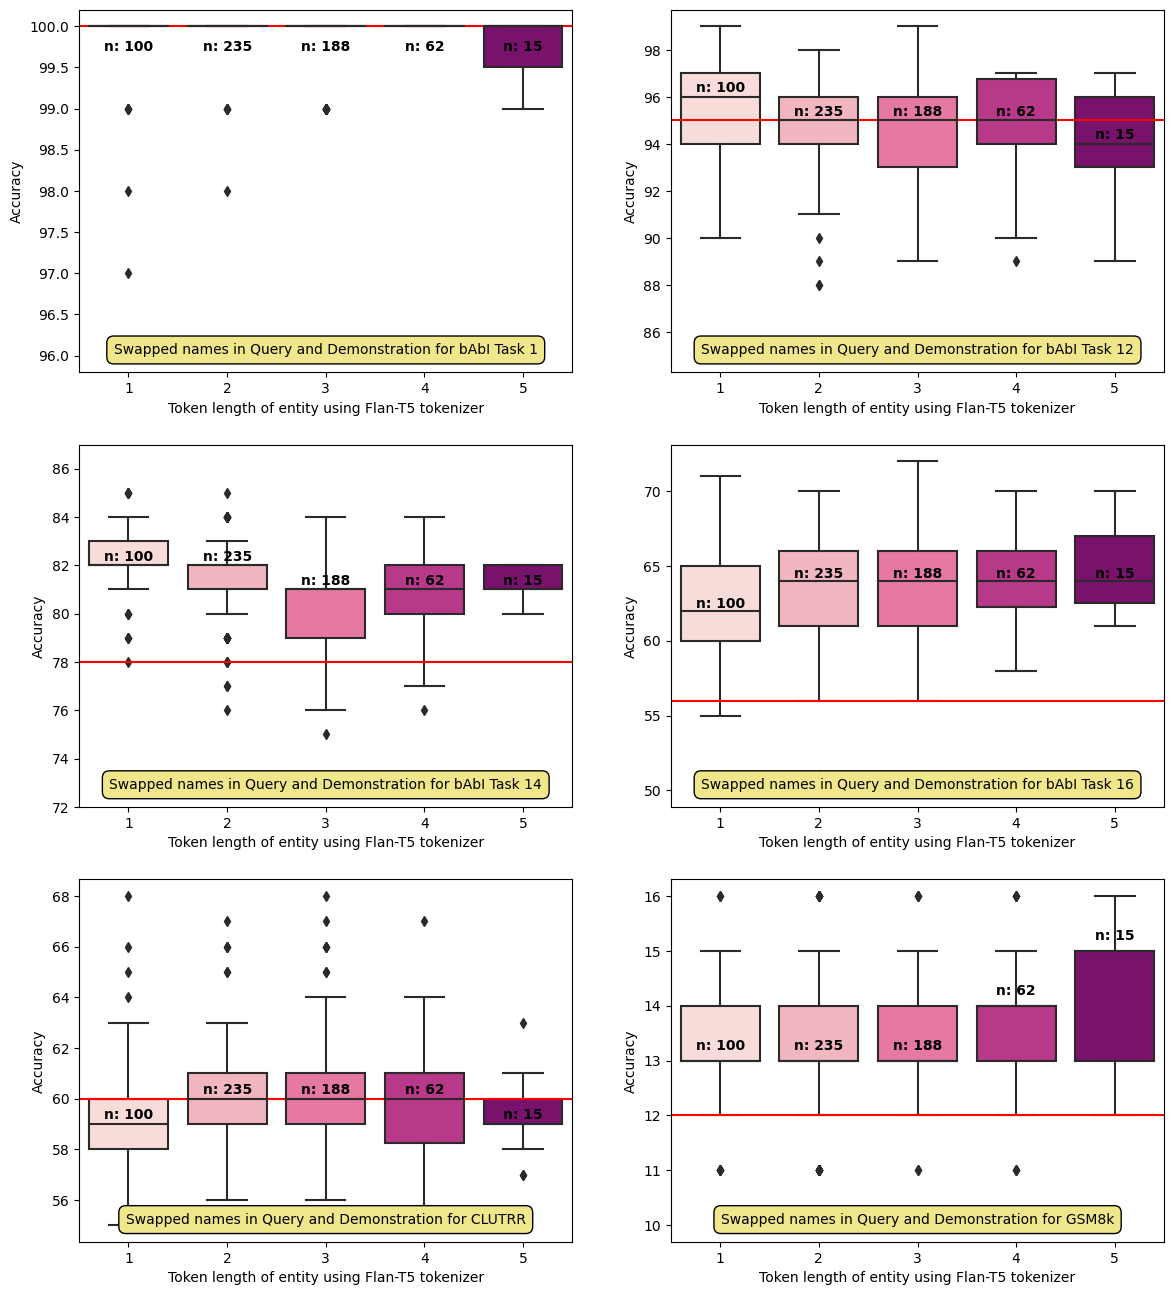

In [36]:
#token_length
fig, ax = plt.subplots(3,2, figsize=(14, 16))  # create a 3x2 grid of subplots
tasks_indexes = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]  # indexes for the 3x2 grid

for i, task in enumerate(allTasks):
    row, col = tasks_indexes[i] 

    unique_token_lengths = df_acc_c['token_len'].unique()
    counts = df_acc_c['token_len'].value_counts()

    sns.boxplot(ax=ax[row, col], x='token_len', y=f"acc_task_{task}", data=df_acc_c, palette='RdPu', order=sorted(unique_token_lengths))
    ax[row, col].set_xlabel('Token length of entity using Flan-T5 tokenizer')
    ax[row, col].set_ylabel('Accuracy')
    ax[row, col].axhline(y=baseline[f'acc_task_{task}'][0], c='r')
    ax[row, col].text(0.5, 0.05, f"Swapped names in Query and Demonstration for {task_to_labels[task]}", horizontalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='khaki', edgecolor='black', boxstyle='round,pad=0.5'))
    if i == 2:
        ax[row, col].set_ylim(72, 87)
        
    for token_len in unique_token_lengths:
        dist_t = -0.3 if i==0 else 0.2
        y = df_acc_c[df_acc_c.token_len == token_len][f'acc_task_{task}'].median() + dist_t
        ax[row, col].text(token_len - 1, y, f'n: {counts[token_len]}', 
                   horizontalalignment='center', size='10', color='black', weight='semibold')
# plt.savefig('../../final_plots/updated_token_len_flan.pdf', bbox_inches='tight', pad_inches=0.2, facecolor='white')
